<a href="https://colab.research.google.com/github/YassineJit/tarfiq/blob/main/RandomForest_S%26P_500.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import pandas as pd
import os

In [ ]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

In [ ]:
sp500.index = pd.to_datetime(sp500.index)

In [ ]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-04-21 00:00:00-04:00,5232.939941,5232.939941,5101.629883,5158.200195,4226340000,0.0,0.0
2025-04-22 00:00:00-04:00,5207.669922,5309.609863,5207.669922,5287.759766,4666950000,0.0,0.0
2025-04-23 00:00:00-04:00,5395.919922,5469.689941,5356.169922,5375.859863,5371390000,0.0,0.0


<Axes: xlabel='Date'>

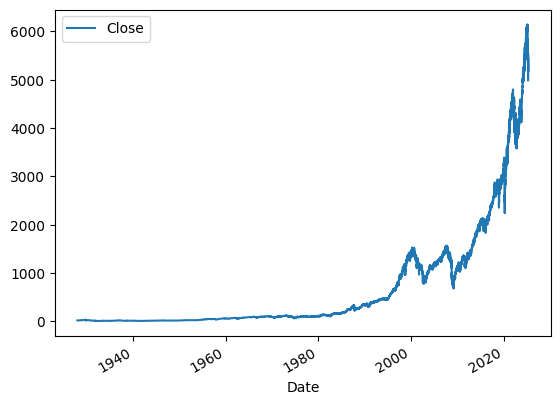

In [ ]:
sp500.plot.line(y="Close", use_index=True)

In [ ]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [ ]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [ ]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [ ]:
sp500.index = pd.to_datetime(sp500.index, utc=True)
sp500.index = sp500.index.tz_convert(None)  # Remove timezone info
sp500 = sp500.loc["1990-01-01":].copy()

In [ ]:
sp500.head()

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1990-01-02 05:00:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03 05:00:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04 05:00:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05 05:00:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08 05:00:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [ ]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5050505050505051

<Axes: xlabel='Date'>

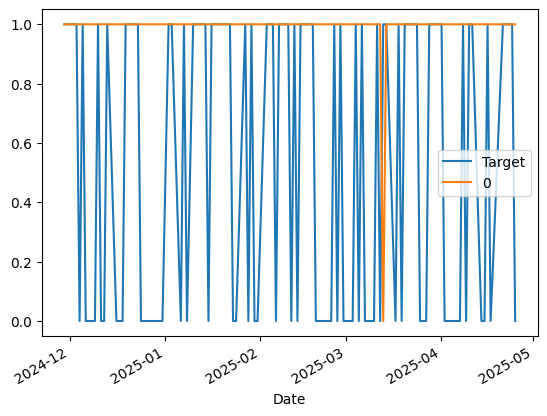

In [ ]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [ ]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [ ]:
predictions = backtest(sp500, model, predictors)

In [ ]:
predictions["Predictions"].value_counts()

,count
Predictions,
0,3736
1,2659


In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5291462955998496

In [ ]:
predictions["Target"].value_counts() / predictions.shape[0]

,count
Target,
1,0.535887
0,0.464113


In [ ]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

    new_predictors+= [ratio_column, trend_column]

In [ ]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [ ]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 05:00:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 05:00:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 05:00:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 05:00:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 05:00:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-21 04:00:00,5232.939941,5232.939941,5101.629883,5158.200195,4226340000,5287.759766,1,0.988076,1.0,0.972541,2.0,0.897447,28.0,0.911688,143.0,1.106343,525.0
2025-04-22 04:00:00,5207.669922,5309.609863,5207.669922,5287.759766,4666950000,5375.859863,1,1.012403,1.0,1.001432,2.0,0.922164,29.0,0.934404,143.0,1.133863,526.0
2025-04-23 04:00:00,5395.919922,5469.689941,5356.169922,5375.859863,5371390000,5484.770020,1,1.008262,2.0,1.018919,3.0,0.939266,30.0,0.949767,143.0,1.152466,526.0


In [ ]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [ ]:
predictions = backtest(sp500, model, new_predictors)

In [ ]:
predictions["Predictions"].value_counts()

,count
Predictions,
0.0,4526
1.0,869


In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

0.570771001150748

In [ ]:
predictions["Target"].value_counts() / predictions.shape[0]

,count
Target,
1,0.54532
0,0.45468


In [ ]:
predictions

,Target,Predictions
Date,,
2003-11-14 05:00:00,0,0.0
2003-11-17 05:00:00,0,1.0
2003-11-18 05:00:00,1,1.0
2003-11-19 05:00:00,0,0.0
2003-11-20 05:00:00,1,1.0
...,...,...
2025-04-21 04:00:00,1,0.0
2025-04-22 04:00:00,1,0.0
2025-04-23 04:00:00,1,0.0
